## Exploratory Analysis in SQL
##### Please use this notebook when loading the full dataset of immigration data

In [1]:
# Import packages
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import configparser
from datetime import datetime
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create Spark session
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "30g") \
    .config('spark.executor.memory','8g') \
    .config('spark.driver.maxResultsSize','0')\
    .appName("Analysis of Immigration Data") \
    .getOrCreate()

In [3]:
# Assign table names
table_name = ['immigration','demographic','state_race','time','mode','visa','port','country','temperature']

In [4]:
# Create views for all tables
for table in table_name:
    df_table=spark.read.parquet("./parquet files/"+table)
    df_table.createOrReplaceTempView(table)
    count_rows = spark.sql('''
        SELECT count(*) FROM {}'''.format(table))
    if count_rows.collect()[0][0] == 0:
        raise ValueError("Data quality check failed. {} returned no results").format(table)

In [5]:
# immigration data
imm = spark.sql('''
    select cicid, 
    c.name as citizen_country,
    c.continent as citizen_continent,
    r.name as residential_country,
    m.mode,
    address_state,
    arrival_date,
    t.month as arrival_month,
    t.weekday as arrival_weekday,
    depart_date,
    datediff(depart_date,arrival_date) as stay_len,
    age,
    birth_year,
    dpmt_visa,
    occupation,
    visa_expiry_date,
    gender,
    airline,
    p.city,
    p.state,
    v.visa,
    visa_code
    from immigration i
    inner join country c on c.code = i.cit_ctry
    inner join country r on r.code = i.res_ctry
    inner join mode m on m.code = i.trnps_mode_code
    inner join port p on p.code = i.port_code
    inner join visa v on v.code = i.visa
    inner join time t on t.date = i.arrival_date
    where gender in ('F','M') 
    and depart_date is not null 
    and age is not null
''')

In [6]:
#imm_df=imm.toPandas()

In [7]:
#imm_df.head()

In [8]:
# Function for annotation
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center",fontsize=12) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

#fig, ax = plt.subplots(1, 2)
#show_values_on_bars(ax)

#### Q: Top 10 country visited U.S

In [9]:
imm.createOrReplaceTempView("imm_table")

In [10]:
top_ctry=spark.sql('''
    select citizen_country, int(count(*)) count from imm_table
    group by citizen_country
    order by count(*) desc
    limit 10
''').toPandas()

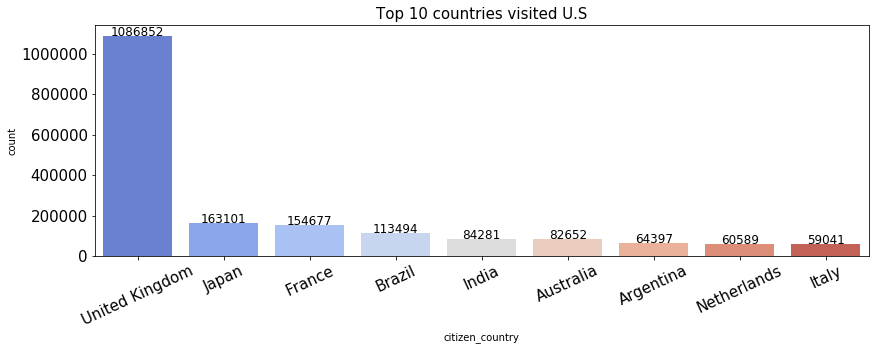

In [11]:
#top_ctry=imm_df_dn['citizen_country'].value_counts()[:10]
fig,ax = plt.subplots(figsize=(12,4))
sns.barplot(top_ctry['citizen_country'],top_ctry['count'],palette = 'coolwarm')
plt.tight_layout()
plt.title("Top 10 countries visited U.S",fontsize=15)
plt.xticks(fontsize=15,rotation=25)
plt.yticks(fontsize=15)
show_values_on_bars(ax)

##### A: UK contributes the most visitors to U.S

#### Q: Top 20 States visited in U.S

In [12]:
top20_state=spark.sql('''
    select address_state, int(count(*)) count from imm_table
    group by address_state
    order by count(*) desc
    limit 20
''').toPandas()

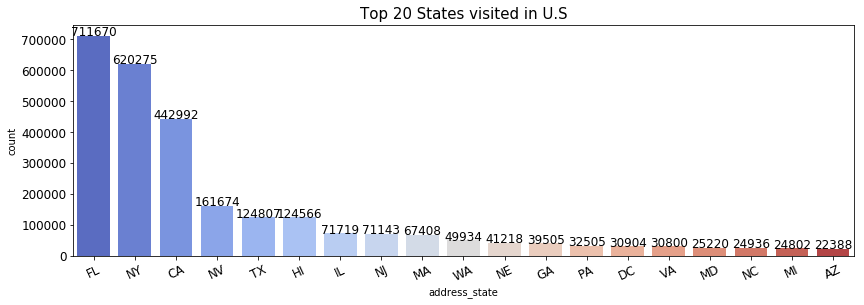

In [19]:
#top20_state=imm_df_dn['address_state'].value_counts()[:20]
fig,ax1 = plt.subplots(figsize=(12,4))
sns.barplot(top20_state['address_state'],top20_state['count'],palette = 'coolwarm')
plt.tight_layout()
plt.title("Top 20 States visited in U.S",fontsize=15)
plt.xticks(fontsize=12,rotation=25)
plt.yticks(fontsize=12)
show_values_on_bars(ax1)

##### A: The most popular State being visited is Florida

#### Q: When do they usually come to U.S?

##### Weekday

In [20]:
weekday=spark.sql('''
    select arrival_weekday, count(*) count
    from imm_table
    group by arrival_weekday''').toPandas()

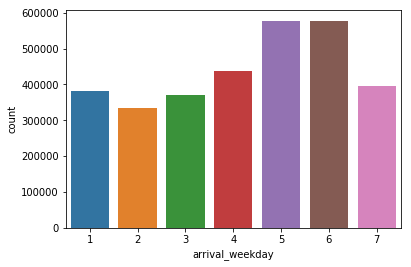

In [21]:
sns.barplot(x='arrival_weekday',y='count',data=weekday)

##### A: In general, the port were expecting more people on Friday and Saturday.

#### Q: How long did they stay?

In [13]:
stay=spark.sql('''
    select age, visa, visa_code, gender, stay_len from imm_table
    where stay_len between 0 and 5000
''').toPandas()

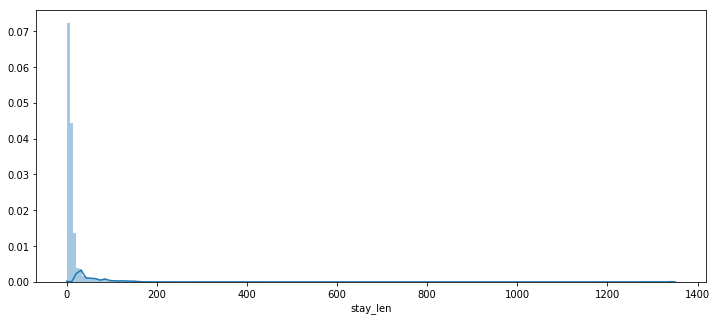

In [15]:
plt.figure(figsize=(12,5))
sns.distplot(stay['stay_len'],bins=200)